In [1]:
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

--2022-12-15 10:11:05--  https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085081 (4.8M) [text/csv]
Saving to: ‘bbc_text_cls.csv’

bbc_text_cls.csv    100%[===================>]   4.85M  --.-KB/s    in 0.09s   

2022-12-15 10:11:05 (56.5 MB/s) - ‘bbc_text_cls.csv’ saved [5085081/5085081]



In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import  train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [3]:
df = pd.read_csv('bbc_text_cls.csv')

In [4]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [6]:
df['targets'] = df['labels'].astype("category").cat.codes

In [7]:
#number of classes
K = df['targets'].max() + 1
K

5

In [8]:
df_train, df_test = train_test_split(df, test_size = 0.3)

In [10]:
#Convert sentences to sequences

MAX_VOCAB_SIZE = 2000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train['text'])
sequences_train = tokenizer.texts_to_sequences(df_train['text'])
sequences_test = tokenizer.texts_to_sequences(df_test['text'])

In [11]:
#get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 27708 unique tokens.


In [12]:
#pad sequences  so that we get  a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of the data train tensor:', data_train.shape)

#get sequences length
T = data_train.shape[1]

Shape of the data train tensor: (1557, 3493)


In [13]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (668, 3493)


In [16]:
from os import XATTR_SIZE_MAX
D = 50
i = Input(shape=(T,))
X = Embedding(V + 1, D)(i)
X = Conv1D(32, 3, activation='relu')(X)

X = GlobalMaxPool1D()(X)
X = Dense(K)(X)

model =  Model(i,X)

In [17]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics=['accuracy']
)

print('Training model ...')
r = model.fit(
    data_train,
    df_train['targets'],
    epochs = 50,
    validation_data=(data_test, df_test['targets'])
)

Training model ...
Epoch 1/50
49/49 [==============================] - 12s 215ms/step - loss: 1.5662 - accuracy: 0.3475 - val_loss: 1.5015 - val_accuracy: 0.5449
Epoch 2/50
49/49 [==============================] - 10s 214ms/step - loss: 1.3472 - accuracy: 0.7039 - val_loss: 1.2013 - val_accuracy: 0.7904
Epoch 3/50
49/49 [==============================] - 10s 214ms/step - loss: 0.9002 - accuracy: 0.8870 - val_loss: 0.7091 - val_accuracy: 0.8862
Epoch 4/50
49/49 [==============================] - 10s 214ms/step - loss: 0.4543 - accuracy: 0.9364 - val_loss: 0.4183 - val_accuracy: 0.9207
Epoch 5/50
49/49 [==============================] - 10s 214ms/step - loss: 0.2482 - accuracy: 0.9595 - val_loss: 0.3072 - val_accuracy: 0.9281
Epoch 6/50
49/49 [==============================] - 12s 243ms/step - loss: 0.1611 - accuracy: 0.9762 - val_loss: 0.2560 - val_accuracy: 0.9341
Epoch 7/50
49/49 [==============================] - 10s 211ms/step - loss: 0.1132 - accuracy: 0.9820 - val_loss: 0.2267 - v

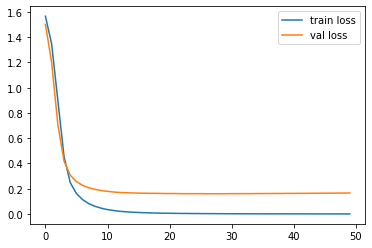

In [18]:
#plot loss per  iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

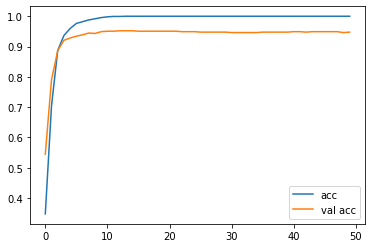

In [19]:
#plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();